# PTPN11
PTPN11 encodes SHP-2, a protein tyrosine phosphatase involved in intracellular signaling pathways that regulate cell growth, differentiation, and survival. It plays a key role in the RAS/MAPK signaling pathway, which is crucial for normal development and oncogenesis. Mutations in this gene are involved in several diseases, including Noonan syndrome and juvenile leukemia.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.4.2.dev0


# PTPN11
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for PTPN11.

In [2]:
gene_symbol = 'PTPN11'
mane_tx_id = 'NM_002834.5'
mane_protein_id = 'NP_002825.3' 

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_name = 'PTPN11'
phenopacket_store_release = '0.1.20'

registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
del phenopackets
validation.summarize()

Individuals Processed: 100%|██████████| 70/70 [00:47<00:00,  1.47individuals/s]
Validated under permissive policy
No errors or warnings were found


In [6]:
from gpsea.view import CohortViewable
from IPython.display import HTML, display

viewer = CohortViewable(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Hypertelorism,HP:0000316,37
Multiple lentigines,HP:0001003,29
Short stature,HP:0004322,26
Pulmonic stenosis,HP:0001642,18
Low-set ears,HP:0000369,18
Ptosis,HP:0000508,15
Webbed neck,HP:0000465,15
Global developmental delay,HP:0001263,13
Multiple enchondromatosis,HP:0005701,12
Multiple exostoses,HP:0002762,12


<Axes: title={'center': 'Tyrosine-protein phosphatase non-receptor type 11\ntranscript: NM_002834.5, protein: NP_002825.3'}>

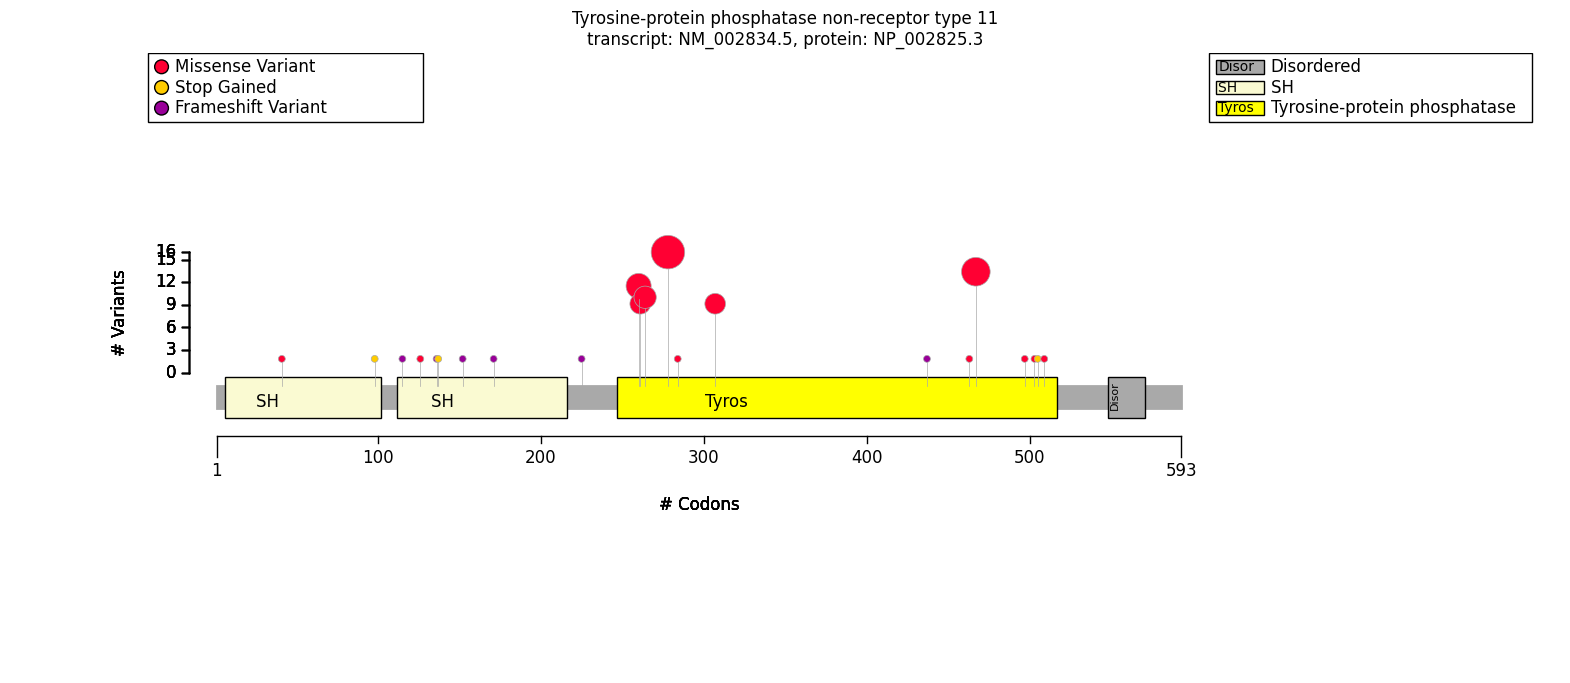

In [8]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService, \
    configure_default_protein_metadata_service

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 

pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizable, ProteinVisualizer

pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

In [9]:
from gpsea.view import ProteinVariantViewer

viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)

Name,Type,Coordinates,Count,Variants
SH2 1,DOMAIN,6 - 102,2,p.Thr42Ala; p.Lys99Ter
SH2 2,DOMAIN,112 - 216,6,p.Thr153LysfsTer8; p.Arg138Ter; p.Ile172GlyfsTer13; p.Ser118TrpfsTer10; p.Val137ArgfsTer17; p.Thr127Ile
Tyrosine-protein phosphatase,DOMAIN,247 - 517,58,p.Arg498Leu; p.Gln506Ter; p.Leu262Phe; p.Arg265Gln; p.Gln510Glu; p.Gly464Ala; p.Met504Val; p.Leu439TrpfsTer33; p.Asn308Asp; p.Thr468Met; p.Phe285Leu; p.Tyr279Cys; p.Leu261His; p.Leu261Phe; p.Leu262Arg
Disordered,REGION,548 - 571,0,


# Genotype phenotype correlation analysis

In [18]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
    missing_implies_excluded=False,
    min_n_of_patients_with_term=2,
)
len(pheno_predicates)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
     term_frequency_threshold=0.2,
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

In [19]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, autosomal_dominant

is_missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
moi_predicate = autosomal_dominant(
    variant_predicate=is_missense,
)
moi_predicate.display_question()

'What is the genotype group: HOM_REF, HET'

In [20]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=moi_predicate,
    pheno_predicates=pheno_predicates,
)

In [21]:
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,6
HMF05,Skipping term because one genotype had zero observations,63
HMF06,Skipping term with less than 7 observations (not powered for 2x2),68
HMF08,Skipping general term,67


In [22]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

What is the genotype group                  HOM_REF            HET          \
                                              Count Percent  Count Percent   
Hypertelorism [HP:0000316]                     0/12      0%  37/41     90%   
Intellectual disability [HP:0001249]           0/12      0%  12/12    100%   
Downslanted palpebral fissures [HP:0000494]    0/12      0%    8/8    100%   
Webbed neck [HP:0000465]                       0/12      0%  15/20     75%   
Posteriorly rotated ears [HP:0000358]          0/12      0%  11/14     79%   
Pulmonic stenosis [HP:0001642]                 0/12      0%  18/34     53%   
Intellectual disability, mild [HP:0001256]     0/12      0%   8/23     35%   

What is the genotype group                                                    
                                            Corrected p values      p values  
Hypertelorism [HP:0000316]                        4.775414e-08  6.822020e-09  
Intellectual disability [HP:0001249]              2.588608e-06  7.396023e-07  
Downslanted palpebral fissures [HP:0000494]       1.852293e-05  7.938398e-06  
Webbed neck [HP:0000465]                          5.148635e-05  2.942077e-05  
Posteriorly rotated ears [HP:0000358]             6.813216e-05  4.866583e-05  
Pulmonic stenosis [HP:0001642]                    1.435355e-03  1.230305e-03  
Intellectual disability, mild [HP:0001256]        3.156028e-02  3.156028e-02